In [3]:
# Let's make this notebook compatible for Python 2 and 3
from __future__ import division, print_function

# Import libraries
import pandas as pd
import numpy as np
import os
import math
import copy

# for visualization
import matplotlib.pyplot as plt

# to import module from parent directory
import sys
sys.path.append('..')

# Dataset API from sklearn
from sklearn import datasets

In [4]:
# Import helper functions
from utils import Plot, accuracy_score, train_test_split
from utils import to_categorical, normalize

from deep_learning.neural_network import NeuralNetwork
from deep_learning.layers import Activation, Dense
from deep_learning.optimizers import Adam
from deep_learning.loss_functions import CrossEntropy

In [5]:
class ParticleSwarmOptimizedNN():
    """ Particle Swarm Optimization of Neural Network.

    Parameters:
    -----------
    n_individuals: int
        The number of neural networks that are allowed in the population at a time.
    model_builder: method
        A method which returns a user specified NeuralNetwork instance.
    inertia_weight:     float [0,1)
    cognitive_weight:   float [0,1)
    social_weight:      float [0,1)
    max_velocity: float
        The maximum allowed value for the velocity.

    Reference:
        Neural Network Training Using Particle Swarm Optimization
        https://visualstudiomagazine.com/articles/2013/12/01/neural-network-training-using-particle-swarm-optimization.aspx 
    """
    def __init__(self, population_size, 
                        model_builder, 
                        inertia_weight=0.8, 
                        cognitive_weight=2, 
                        social_weight=2, 
                        max_velocity=20):
        self.population_size = population_size
        self.model_builder = model_builder
        self.best_individual = None
        # Parameters used to update velocity
        self.cognitive_w = cognitive_weight
        self.inertia_w = inertia_weight
        self.social_w = social_weight
        self.min_v = -max_velocity
        self.max_v = max_velocity

    def _build_model(self, id):
        """ Returns a new individual """
        model = self.model_builder(n_inputs=self.X.shape[1], n_outputs=self.y.shape[1])
        model.id = id
        model.fitness = 0
        model.highest_fitness = 0
        model.accuracy = 0
        # Set intial best as the current initialization
        model.best_layers = copy.copy(model.layers)

        # Set initial velocity to zero
        model.velocity = []
        for layer in model.layers:
            velocity = {"W": 0, "w0": 0}
            if hasattr(layer, 'W'):
                velocity = {"W": np.zeros_like(layer.W), "w0": np.zeros_like(layer.w0)}
            model.velocity.append(velocity)

        return model

    def _initialize_population(self):
        """ Initialization of the neural networks forming the population"""
        self.population = []
        for i in range(self.population_size):
            model = self._build_model(id=i)
            self.population.append(model)

    def _update_weights(self, individual):
        """ Calculate the new velocity and update weights for each layer """
        # Two random parameters used to update the velocity
        r1 = np.random.uniform()
        r2 = np.random.uniform()
        for i, layer in enumerate(individual.layers):
            if hasattr(layer, 'W'):
                # Layer weights velocity
                first_term_W = self.inertia_w * individual.velocity[i]["W"]
                second_term_W = self.cognitive_w * r1 * (individual.best_layers[i].W - layer.W)
                third_term_W = self.social_w * r2 * (self.best_individual.layers[i].W - layer.W)
                new_velocity = first_term_W + second_term_W + third_term_W
                individual.velocity[i]["W"] = np.clip(new_velocity, self.min_v, self.max_v)

                # Bias weight velocity
                first_term_w0 = self.inertia_w * individual.velocity[i]["w0"]
                second_term_w0 = self.cognitive_w * r1 * (individual.best_layers[i].w0 - layer.w0)
                third_term_w0 = self.social_w * r2 * (self.best_individual.layers[i].w0 - layer.w0)
                new_velocity = first_term_w0 + second_term_w0 + third_term_w0
                individual.velocity[i]["w0"] = np.clip(new_velocity, self.min_v, self.max_v)

                # Update layer weights with velocity
                individual.layers[i].W += individual.velocity[i]["W"]
                individual.layers[i].w0 += individual.velocity[i]["w0"]
        
    def _calculate_fitness(self, individual):
        """ Evaluate the individual on the test set to get fitness scores """
        loss, acc = individual.test_on_batch(self.X, self.y)
        individual.fitness = 1 / (loss + 1e-8)
        individual.accuracy = acc

    def evolve(self, X, y, n_generations):
        """ Will evolve the population for n_generations based on dataset X and labels y"""
        self.X, self.y = X, y

        self._initialize_population()

        # The best individual of the population is initialized as population's first ind.
        self.best_individual = copy.copy(self.population[0])

        for epoch in range(n_generations):
            for individual in self.population:
                # Calculate new velocity and update the NN weights
                self._update_weights(individual)
                # Calculate the fitness of the updated individual
                self._calculate_fitness(individual)

                # If the current fitness is higher than the individual's previous highest
                # => update the individual's best layer setup
                if individual.fitness > individual.highest_fitness:
                    individual.best_layers = copy.copy(individual.layers)
                    individual.highest_fitness = individual.fitness
                # If the individual's fitness is higher than the highest recorded fitness for the
                # whole population => update the best individual
                if individual.fitness > self.best_individual.fitness:
                    self.best_individual = copy.copy(individual)

            print ("[%d Best Individual - ID: %d Fitness: %.5f, Accuracy: %.1f%%]" % (epoch,
                                                                            self.best_individual.id,
                                                                            self.best_individual.fitness,
                                                                            100*float(self.best_individual.accuracy)))
        return self.best_individual


+---------------+
| Model Summary |
+---------------+
Input Shape: (4,)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Dense                | 80         | (16,)        |
| Activation (ReLU)    | 0          | (16,)        |
| Dense                | 51         | (3,)         |
| Activation (Softmax) | 0          | (3,)         |
+----------------------+------------+--------------+
Total Parameters: 131

Population Size: 100
Generations: 10

Inertia Weight: 0.80
Cognitive Weight: 0.80
Social Weight: 0.80

[0 Best Individual - ID: 66 Fitness: 1.59377, Accuracy: 33.3%]
[1 Best Individual - ID: 54 Fitness: 1.70958, Accuracy: 68.9%]
[2 Best Individual - ID: 71 Fitness: 2.36029, Accuracy: 68.9%]
[3 Best Individual - ID: 79 Fitness: 4.16412, Accuracy: 90.0%]
[4 Best Individual - ID: 96 Fitness: 9.08700, Accuracy: 94.4%]
[5 Best Individual - ID: 63 Fitness: 9.84725, Accuracy: 94.4%]

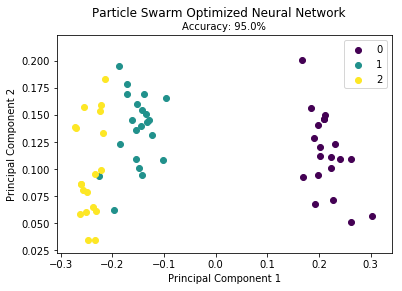

In [6]:
def main():

    X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=4, n_clusters_per_class=1, n_informative=2)

    data = datasets.load_iris()
    X = normalize(data.data)
    y = data.target
    y = to_categorical(y.astype("int"))

    # Model builder
    def model_builder(n_inputs, n_outputs):    
        model = NeuralNetwork(optimizer=Adam(), loss=CrossEntropy)
        model.add(Dense(16, input_shape=(n_inputs,)))
        model.add(Activation('relu'))
        model.add(Dense(n_outputs))
        model.add(Activation('softmax'))

        return model

    # Print the model summary of a individual in the population
    print ("")
    model_builder(n_inputs=X.shape[1], n_outputs=y.shape[1]).summary()

    population_size = 100
    n_generations = 10

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=1)

    inertia_weight = 0.8
    cognitive_weight = 0.8
    social_weight = 0.8

    print ("Population Size: %d" % population_size)
    print ("Generations: %d" % n_generations)
    print ("")
    print ("Inertia Weight: %.2f" % inertia_weight)
    print ("Cognitive Weight: %.2f" % cognitive_weight)
    print ("Social Weight: %.2f" % social_weight)
    print ("")

    model = ParticleSwarmOptimizedNN(population_size=population_size, 
                        inertia_weight=inertia_weight,
                        cognitive_weight=cognitive_weight,
                        social_weight=social_weight,
                        max_velocity=5,
                        model_builder=model_builder)
    
    model = model.evolve(X_train, y_train, n_generations=n_generations)

    loss, accuracy = model.test_on_batch(X_test, y_test)

    print ("Accuracy: %.1f%%" % float(100*accuracy))

    # Reduce dimension to 2D using PCA and plot the results
    y_pred = np.argmax(model.predict(X_test), axis=1)
    Plot().plot_in_2d(X_test, y_pred, title="Particle Swarm Optimized Neural Network", accuracy=accuracy, legend_labels=range(y.shape[1]))


if __name__ == "__main__":
    main()